### Reference:
1. A Quantum Engineer's Guide to Superconducting Qubits by William Oliver https://arxiv.org/pdf/1904.06560

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from IPython.display import display, Markdown, Latex
from matplotlib import cm
import imageio
from matplotlib import colors as mpl_colors

In [2]:
kmax = 5
alpha = 300e6 * 2 * np.pi  # α = −EC is usually designed to be 100 − 300 MHz
detuning = alpha / 2
wq = 5e9 * 2 * np.pi   # ωq = ((√8EJEC)−EC) =3−6 GHz # Typical qubits are designed at frequency ωq/2π ≈ 5 GHz
wd = wq + detuning
phi_d = np.pi / 4
Gate_duration = 20e-9
t_0 = Gate_duration / 2
sigma = Gate_duration / 4
amp = 60e6 * 2 * np.pi
dragamp = 15e6 * 2 * np.pi
Q = np.sin(phi_d)
I = np.cos(phi_d)
λ = 0.5                   # optimal choice for reducing leakage error
B = (-λ**2) / 4 / alpha
tList = np.arange(0, Gate_duration, 1e-12)

# Pulses
The formula for a Gaussian drive pulse is: \
$f(t) = A \exp\left(-\frac{(t-t_0)^2}{2\sigma^2}\right)$

$\frac{df}{dt} = -\frac{A}{\sigma^2} (t-t_0) \exp\left(-\frac{(t-t_0)^2}{2\sigma^2}\right)$ 

And DRAG  drive pulse is: 

$G(t) = f(t) -i\beta\frac{df}{dt} $ 

$\beta= \frac{\lambda^2}{4\alpha}$

where:

$A$ is the amplitude of the pulse \
$t_0$ is the center time of the pulse \
$\sigma$ is the standard deviation of the Gaussian envelope \
$f_c$ is the center frequency of the pulse \
$\beta$ is the amplitude of the DRAG pulse
$\lambda$ is the DRAG parameter which is {0.5,1}

In [3]:
def gaussian(t, args):
    return np.exp(-((t - args["t_0"]) / args["sigma"])**2 / 2)

def gaussian_drive(t, args):
    return args["I"] * np.sin(args["wd"] * t) * gaussian(t, args)

def DRAG(t, args):
    return -(t - args["t_0"]) / args["sigma"] * np.exp(-((t - args["t_0"]) / args["sigma"])**2 / 2)

def DRAG_drive(t, args):
    return args["Q"] * np.cos((args["wd"] * t) + np.pi) * DRAG(t, args)

args = {'t_0': t_0, 'sigma': sigma , 'wd': wd, 'wq': wq ,'I': I, 'Q': Q}

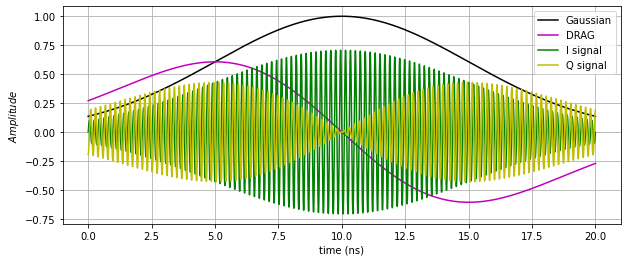

In [4]:
plt.figure(figsize=(10, 4))
plt.plot(tList * 1e9, gaussian(tList, args=args), "k-")
plt.plot(tList * 1e9, DRAG(tList, args=args), "m-")
plt.plot(tList * 1e9, gaussian_drive(tList, args=args), "g-")
plt.plot(tList * 1e9, DRAG_drive(tList, args=args), "y-")

plt.legend([r"Gaussian", r"DRAG", r"I signal", r"Q signal"], loc="best")
plt.rc('grid', linestyle=":", color='black')
plt.xlabel(r'time (ns)')
plt.ylabel(r'$ Amplitude $')
plt.grid(True)

# Hamiltonian before Rotating Frame Approximation (RFA)
REF :
1. https://qudev.phys.ethz.ch/static/content/courses/QSIT12/QSIT12_qubitmanipulation.pdf
2. https://arxiv.org/pdf/1904.06560
### Definition of the Transmon Qubit Hamiltonian in Python

The given Hamiltonian represents a transmon qubit with additional terms for control fields, such as the DRAG term (which mitigates leakage errors) and a signal drive term.
$$H_0 = w_q \cdot b^\dagger b + \frac{\alpha}{2} \cdot (b^\dagger b)^2$$
- $H_0$ represents the qubit's base Hamiltonian, which includes the transmon qubit's energy levels and a nonlinear term corresponding to the anharmonicity of the qubit. $w_q$ is the qubit frequency, $b^\dagger b$ represents the number operator. The term $\frac{I}{2}$ shifts the energy of all states by a constant factor, commonly used to set the zero-point energy or to account for the offset in the system.

$$H_{d}(\sigma_x) = \text{amp} \cdot (b + b^\dagger)$$

$$H_{d}(\sigma_y) = \text{dragamp} \cdot \left(1j \cdot (b - b^\dagger)\right)$$
- $H_d(\sigma_x)$ and $H_d(\sigma_y)$ represent the control fields used to manipulate the qubit. $H_{d}(\sigma_x)$ represents the control Hamiltonian for a $\sigma_x$  operation (also called a bit-flip operation), and $H_{d}(\sigma_y)$ represents the control Hamiltonian for a $\sigma_y$ operation (a phase-flip operation)

In [5]:
b = destroy(kmax)
H0 = wq * (b.dag() * b) + alpha / 2 * (b.dag() * b)**2
Hd_sigmax = amp * (b + b.dag())
Hd_sigmay = dragamp * (1j * (b - b.dag()))

In [6]:
H = [H0, [Hd_sigmax, gaussian_drive], [Hd_sigmay, DRAG_drive]]
c_ops = []
opts = Options(atol=1e-12, rtol=1e-10, store_states=True, nsteps=1e7)
result = mesolve(H, ket2dm(fock(kmax, 0)), tList, c_ops, [], args=args, options=opts, progress_bar=True)

10.0%. Run time:   0.11s. Est. time left: 00:00:00:00


C:\Users\Hannaneh\AppData\Roaming\Python\Python39\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
C:\Users\Hannaneh\AppData\Roaming\Python\Python39\site-packages\qutip\solver\solver_base.py:459: FutureWarning: "progress_bar" is now included in options:
 Use `options={"progress_bar": False / True / "tqdm" / "enhanced"}`
  warnings.warn(


20.0%. Run time:   0.24s. Est. time left: 00:00:00:00
30.0%. Run time:   0.41s. Est. time left: 00:00:00:00
40.0%. Run time:   0.57s. Est. time left: 00:00:00:00
50.0%. Run time:   0.71s. Est. time left: 00:00:00:00
60.0%. Run time:   0.85s. Est. time left: 00:00:00:00
70.0%. Run time:   0.99s. Est. time left: 00:00:00:00
80.0%. Run time:   1.12s. Est. time left: 00:00:00:00
90.0%. Run time:   1.24s. Est. time left: 00:00:00:00
100.0%. Run time:   1.37s. Est. time left: 00:00:00:00
Total run time:   1.37s


In [7]:
def calculate_probability_from_dm(res):
    dms = res.states
    probabilities = []
    for dm in dms:
        probabilities.append(dm.diag())
    return np.array(probabilities)

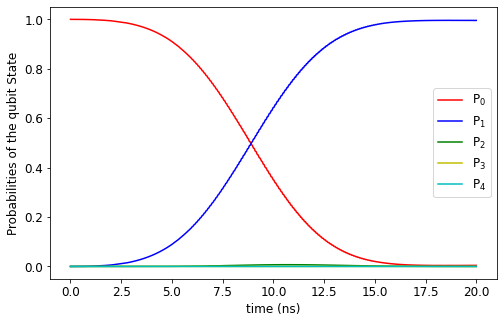

In [8]:
probabilities = calculate_probability_from_dm(result)
plt.figure(figsize=(8, 5))
plt.plot(tList*1e9, probabilities[:,0], 'r')
plt.plot(tList*1e9, probabilities[:,1], 'b')
plt.plot(tList*1e9, probabilities[:,2], 'g')
plt.plot(tList*1e9, probabilities[:,3], 'y')
plt.plot(tList*1e9, probabilities[:,4], 'c')


plt.xlabel("time (ns)", fontsize=12)
plt.ylabel("Probabilities of the qubit State", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.rc('grid', linestyle=":", color='black')
plt.legend([r"$\mathrm{P_0}$", r"$\mathrm{P_1}$", r"$\mathrm{P_2}$", r"$\mathrm{P_3}$",r"$\mathrm{P_4}$"], loc='best' , fontsize=12)

In [9]:
probabilities[-1,1]

np.float64(0.9956662773824068)

In [10]:
result.states[19999]#.full

Quantum object: dims=[[5], [5]], shape=(5, 5), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 4.29482705e-03+7.55002783e-16j -2.25708256e-02-6.13740317e-02j
   4.07768701e-04-2.78181672e-05j -7.95504712e-08+9.27790946e-07j
  -1.10378587e-09-2.27537208e-10j]
 [-2.25708256e-02+6.13740317e-02j  9.95666277e-01-7.45742311e-16j
  -1.74543069e-03+5.97331426e-03j -1.28396416e-05-6.01577428e-06j
   8.94024838e-09-1.45843511e-08j]
 [ 4.07768701e-04+2.78181672e-05j -1.74543069e-03-5.97331426e-03j
   3.88953680e-05-8.52488702e-18j -1.35812394e-08+8.75790126e-08j
  -1.02907324e-10-2.81020873e-11j]
 [-7.95504712e-08-9.27790946e-07j -1.28396416e-05+6.01577428e-06j
  -1.35812394e-08-8.75790126e-08j  2.02144990e-10-1.60722833e-19j
  -2.67646998e-14+2.34490397e-13j]
 [-1.10378587e-09+2.27537208e-10j  8.94024838e-09+1.45843511e-08j
  -1.02907324e-10+2.81020874e-11j -2.67647080e-14-2.34490399e-13j
   1.26625820e-15-1.36006261e-22j]]

In [11]:
target = np.array([[0, 0, 0, 0 , 0],
                  [0, 1, 0, 0 , 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 0 , 0],
                  [0, 0, 0, 0 , 0]])
state_matrix = result.states[19999].full()
fidelity = np.abs(np.trace(np.dot(state_matrix, target)))
#np.dot() : a matrix multiplication between the density matrix and the target matrix
print("Fidelity Percentage:", fidelity * 100, "%")

Fidelity Percentage: 99.56662773824067 %


# Tune the pulse amplitudes:
##### 1. Gaussian amplitude:

In [12]:
kmax = 5
alpha = 300e6 * 2 * np.pi
detuning = alpha / 2
wq = 5e9 * 2 * np.pi
wd = wq + detuning
phi_d = np.pi / 4
Gate_duration = 20e-9
t_0 = Gate_duration / 2
sigma = Gate_duration / 4
Q = np.sin(phi_d)
I = np.cos(phi_d)
λ = 0.1
B = (-λ**2) / 4 / alpha
tList = np.arange(0, Gate_duration, 1e-12)

args = {'t_0': t_0,'wd': wd,'wq': wq,'sigma': sigma,'I': I,'Q': Q,'amplitude': 1,'dragamplitude': 0}

def gaussian(t, args):
    return args["amplitude"] * np.exp(-((t - args["t_0"]) / args["sigma"])**2 / 2)

def gaussian_drive(t, args):
    return args["I"] * np.sin(args["wd"] * t) * gaussian(t, args)

def DRAG(t, args):
    return -args["dragamplitude"] *(t - args["t_0"]) / args["sigma"] * np.exp(-((t - args["t_0"]) / args["sigma"])**2 / 2)

def DRAG_drive(t, args):
    return args["Q"] * np.cos((args["wd"] * t) + np.pi ) * DRAG(t, args)

def Hamiltonian_end(amplitudes):
    b = destroy(kmax)
    amp = amplitudes[0]
    dragamp = amplitudes[1]
    H0 = wq * (b.dag() * b) + alpha / 2 * (b.dag() * b) ** 2
    Hd_sigmax = amp * (b + b.dag())
    Hd_sigmay = dragamp * (1j * (b - b.dag()))
    H = [H0,[Hd_sigmax, gaussian_drive],[Hd_sigmay, DRAG_drive]]
    opts = Options(atol=1e-12, rtol=1e-10, store_states=True, nsteps=1e7)
    result = mesolve(H,ket2dm(fock(kmax, 0)),tList,[],[],args=args,options=opts)
    return result.states[-1]

ampList = np.linspace(50e6*2*np.pi, 70e6*2*np.pi, 200)
dragampList = 0.0
argList_amp = [(amp, dragampList) for amp in ampList]

UList_amp = []
for args_amp in argList_amp:
    UList_amp.append(Hamiltonian_end(args_amp))

all_probabilities = np.array([[np.real(state.diag()[i]) for i in range(kmax)]for state in UList_amp])

optimal_index = np.argmax(all_probabilities[:, 1])
optimal_gaussian_amplitude = ampList[optimal_index]

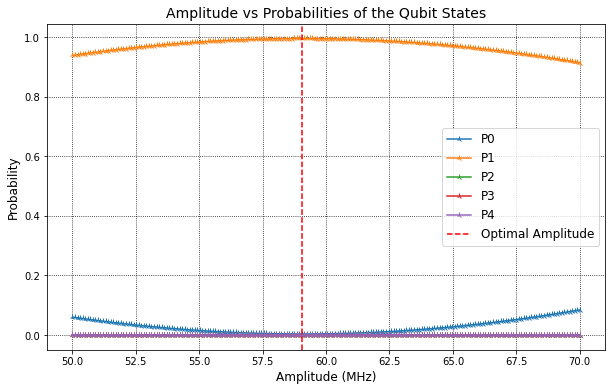

In [13]:
optimal_gaussian_amplitude2=optimal_gaussian_amplitude/(2 * np.pi * 1e6)
plt.figure(figsize=(10, 6))
for i in range(kmax):
    plt.plot((ampList/(2 * np.pi * 1e6)),all_probabilities[:, i],label=f'P{i}', marker='2')  # 2 :tri_up symbol

plt.axvline(optimal_gaussian_amplitude2, color='r', linestyle='--', label='Optimal Amplitude')
plt.xlabel("Amplitude (MHz)", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.title("Amplitude vs Probabilities of the Qubit States", fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.grid(True)
plt.show()

In [14]:
print(f" Real Optimal Amplitude: {optimal_gaussian_amplitude} MHz")
print(f"Optimal Amplitude: {optimal_gaussian_amplitude / (2 * np.pi * 1e6)} MHz")
print(f"Maximum Probability for |1>: {all_probabilities[optimal_index, 1]}")

 Real Optimal Amplitude: 370992097.2832168 MHz
Optimal Amplitude: 59.04522613065327 MHz
Maximum Probability for |1>: 0.996330716768245


##### 2. DRAG amplitude:

In [15]:
args = {'t_0':t_0,'wd':wd,'wq':wq,'sigma':sigma,'I':I,'Q':Q,'amplitude':1,'dragamplitude': 1}

gaussian_amplitude = optimal_gaussian_amplitude
dragampList = np.linspace(1e6*2*np.pi, 15e6*2*np.pi , 100)
argList_drag = [(gaussian_amplitude, dragamp) for dragamp in dragampList]

UList_drag = []
for args_drag in argList_drag:
    UList_drag.append(Hamiltonian_end(args_drag))

all_probabilities_drag = np.array([[np.real(state.diag()[i]) for i in range(kmax)] for state in UList_drag])

optimal_index_drag = np.argmax(all_probabilities_drag[:, 1])
optimal_drag_amplitude = dragampList[optimal_index_drag]

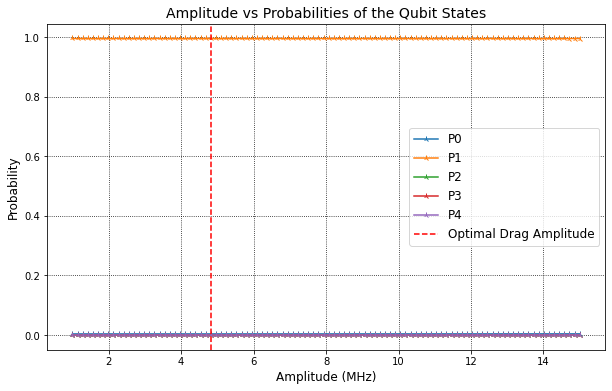

In [16]:
plt.figure(figsize=(10, 6))
for i in range(kmax):
    plt.plot(dragampList / (2 * np.pi * 1e6), all_probabilities_drag[:, i], label=f'P{i}', marker='2')  # 2 :triangle up symbol

plt.axvline(optimal_drag_amplitude / (2 * np.pi * 1e6), color='r', linestyle='--', label='Optimal Drag Amplitude')

plt.xlabel("Amplitude (MHz)", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.title("Amplitude vs Probabilities of the Qubit States", fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.grid(True)
plt.show()

In [17]:
print(f"Optimal DRAG Amplitude: {optimal_drag_amplitude / (2 * np.pi * 1e6)} MHz")
print(f"Maximum Probability for |1>: {all_probabilities_drag[optimal_index_drag, 1]}")

Optimal DRAG Amplitude: 4.818181818181818 MHz
Maximum Probability for |1>: 0.9963594315484898


In [18]:
fidelity_gaussian = all_probabilities[optimal_index, 1]
fidelity_drag = all_probabilities_drag[optimal_index_drag, 1]

if fidelity_gaussian < fidelity_drag:
    fidelity_increase = ((fidelity_drag - fidelity_gaussian) / fidelity_gaussian) * 100
    print("DRAG protocol works correctly.")
    print(f"The fidelity increased by {fidelity_increase:.4f}%.")
else:
    print("DRAG protocol does not work correctly.")
    fidelity_decrease = ((fidelity_gaussian - fidelity_drag) / fidelity_gaussian) * 100
    print(f"The fidelity decreased by {fidelity_decrease:.4f}%.")

DRAG protocol works correctly.
The fidelity increased by 0.0029%.


In [19]:
print(optimal_gaussian_amplitude,'for 20 ns')                                   # 370992097.2832168 for 20 ns
print(optimal_drag_amplitude,'for 20 ns')                               # 30273529.207319822 for 20 ns
print(optimal_gaussian_amplitude/ (2 * np.pi * 1e6),'MHz for 20 ns')            # 59.04522613065327 MHz for 20 ns
print(optimal_drag_amplitude/ (2 * np.pi * 1e6),'MHz for 20 ns')        # 4.818181818181818 MHz for 20 ns

370992097.2832168 for 20 ns
30273529.207319822 for 20 ns
59.04522613065327 MHz for 20 ns
4.818181818181818 MHz for 20 ns


# The final optimized Hamiltonian

10.0%. Run time:   0.17s. Est. time left: 00:00:00:01
20.0%. Run time:   0.35s. Est. time left: 00:00:00:01
30.0%. Run time:   0.55s. Est. time left: 00:00:00:01
40.0%. Run time:   0.78s. Est. time left: 00:00:00:01
50.0%. Run time:   1.05s. Est. time left: 00:00:00:01
60.0%. Run time:   1.29s. Est. time left: 00:00:00:00
70.0%. Run time:   1.66s. Est. time left: 00:00:00:00
80.0%. Run time:   1.85s. Est. time left: 00:00:00:00
90.0%. Run time:   2.04s. Est. time left: 00:00:00:00
100.0%. Run time:   2.25s. Est. time left: 00:00:00:00
Total run time:   2.25s


Quantum object: dims=[[5], [5]], shape=(5, 5), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 3.52716008e-03-1.25085334e-15j  2.46183738e-03-5.92305496e-02j
   6.12744157e-04+1.56677391e-04j -9.66831077e-07+2.47164103e-06j
  -5.56348918e-09-2.71395684e-09j]
 [ 2.46183738e-03+5.92305496e-02j  9.96359432e-01+1.23425748e-15j
  -2.20334990e-03+1.03989893e-02j -4.21796396e-05-1.45122131e-05j
   4.17535863e-08-9.54058618e-08j]
 [ 6.12744157e-04-1.56677391e-04j -2.20334990e-03-1.03989893e-02j
   1.13406371e-04+1.59990715e-17j -5.81876288e-08+4.72322307e-07j
  -1.08800875e-09-2.24667677e-10j]
 [-9.66831077e-07-2.47164103e-06j -4.21796396e-05+1.45122131e-05j
  -5.81876288e-08-4.72322307e-07j  1.99724410e-09-6.16288930e-20j
  -3.75572044e-13+4.64661815e-12j]
 [-5.56348918e-09+2.71395683e-09j  4.17535863e-08+9.54058618e-08j
  -1.08800875e-09+2.24667677e-10j -3.75572047e-13-4.64661815e-12j
   1.18715943e-14-7.78951033e-23j]]

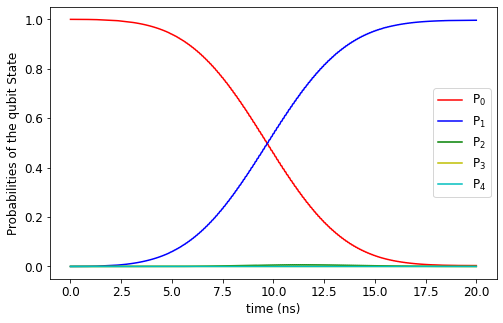

In [20]:
kmax = 5
alpha = 300e6 * 2 * np.pi 
detuning = alpha / 2
wq = 5e9 * 2 * np.pi 
wd = wq + detuning
phi_d = np.pi / 4
Gate_duration = 20e-9
t_0 = Gate_duration / 2
sigma = Gate_duration / 4
amp = optimal_gaussian_amplitude
dragamp = optimal_drag_amplitude
Q = np.sin(phi_d)
I = np.cos(phi_d)
λ = 0.1
B = (-λ**2) / 4 / alpha
tList = np.arange(0, Gate_duration, 1e-12)

def gaussian(t, args):
    return np.exp(-((t - args["t_0"]) / args["sigma"])**2 / 2)

def gaussian_drive(t, args):
    return args["I"] * np.sin(args["wd"] * t) * gaussian(t, args)

def DRAG(t, args):
    return -(t - args["t_0"]) / args["sigma"] * np.exp(-((t - args["t_0"]) / args["sigma"])**2 / 2)

def DRAG_drive(t, args):
    return args["Q"] * np.cos((args["wd"] * t) + np.pi) * DRAG(t, args)

args = {'t_0': t_0, 'sigma': sigma , 'wd': wd, 'wq': wq ,'I': I, 'Q': Q}

b = destroy(kmax)
H0 = wq * (b.dag() * b) + alpha / 2 * (b.dag() * b)**2
Hd_sigmax = amp * (b + b.dag())
Hd_sigmay = dragamp * (1j * (b - b.dag()))

H = [H0, [Hd_sigmax, gaussian_drive], [Hd_sigmay, DRAG_drive]]
c_ops = []
opts = Options(atol=1e-12, rtol=1e-10, store_states=True, nsteps=1e7)
result = mesolve(H, ket2dm(fock(kmax, 0)), tList, c_ops, [], args=args, options=opts, progress_bar=True)

probabilities = calculate_probability_from_dm(result)
plt.figure(figsize=(8, 5))
plt.plot(tList*1e9, probabilities[:,0], 'r')
plt.plot(tList*1e9, probabilities[:,1], 'b')
plt.plot(tList*1e9, probabilities[:,2], 'g')
plt.plot(tList*1e9, probabilities[:,3], 'y')
plt.plot(tList*1e9, probabilities[:,4], 'c')


plt.xlabel("time (ns)", fontsize=12)
plt.ylabel("Probabilities of the qubit State", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.rc('grid', linestyle=":", color='black')
plt.legend([r"$\mathrm{P_0}$", r"$\mathrm{P_1}$", r"$\mathrm{P_2}$", r"$\mathrm{P_3}$",r"$\mathrm{P_4}$"], loc='best' , fontsize=12)

result.states[19999]#.full

### X gate

In [21]:
nmax = 2
b = destroy(nmax)
sigma_x = sigmax()
sigma__x = b + b.dag()

print(sigma_x)
print(sigma__x)
print(sigma_x == sigma__x)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]
True


10.0%. Run time:   0.14s. Est. time left: 00:00:00:01
20.0%. Run time:   0.27s. Est. time left: 00:00:00:01
30.0%. Run time:   0.46s. Est. time left: 00:00:00:01
40.0%. Run time:   0.71s. Est. time left: 00:00:00:01
50.0%. Run time:   0.86s. Est. time left: 00:00:00:00
60.0%. Run time:   1.04s. Est. time left: 00:00:00:00
70.0%. Run time:   1.21s. Est. time left: 00:00:00:00
80.0%. Run time:   1.39s. Est. time left: 00:00:00:00
90.0%. Run time:   1.56s. Est. time left: 00:00:00:00
100.0%. Run time:   1.71s. Est. time left: 00:00:00:00
Total run time:   1.71s
0.996330716768245


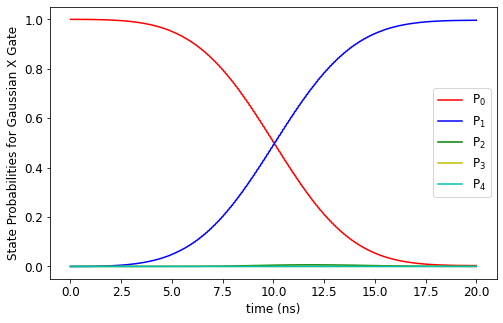

In [43]:
kmax = 5
alpha = 300e6 * 2 * np.pi 
detuning = alpha / 2
wq = 5e9 * 2 * np.pi 
wd = wq + detuning
phi_d = np.pi / 4
Gate_duration = 20e-9
t_0 = Gate_duration / 2
sigma = Gate_duration / 4
amp = optimal_gaussian_amplitude
dragamp = optimal_drag_amplitude
Q = np.sin(phi_d)
I = np.cos(phi_d)
λ = 0.1
B = (-λ**2) / 4 / alpha
tList = np.arange(0, Gate_duration, 1e-12)

def gaussian(t, args):
    return np.exp(-((t - args["t_0"]) / args["sigma"])**2 / 2)

def gaussian_drive_x(t, args):
    return args["I"] * np.sin(args["wd"] * t) * gaussian(t, args)

args = {'t_0': t_0, 'sigma': sigma , 'wd': wd, 'wq': wq ,'I': I, 'Q': Q}

b = destroy(kmax)
H0 = wq * (b.dag() * b) + alpha / 2 * (b.dag() * b)**2
Hd_sigmax = amp * (b + b.dag())
Hd_sigmay = amp * (1j * (b - b.dag()))
H_x = [H0, [Hd_sigmax, gaussian_drive_x]]
c_ops = []
opts = Options(atol=1e-12, rtol=1e-10, store_states=True, nsteps=1e7)
result_x = mesolve(H_x, ket2dm(fock(kmax, 0)), tList, c_ops, [], args=args, options=opts, progress_bar=True)

probabilities_x = calculate_probability_from_dm(result_x)
print(probabilities_x[-1,1])
plt.figure(figsize=(8, 5))
plt.plot(tList*1e9, probabilities_x[:,0], 'r')
plt.plot(tList*1e9, probabilities_x[:,1], 'b')
plt.plot(tList*1e9, probabilities_x[:,2], 'g')
plt.plot(tList*1e9, probabilities_x[:,3], 'y')
plt.plot(tList*1e9, probabilities_x[:,4], 'c')
plt.xlabel("time (ns)", fontsize=12)
plt.ylabel("State Probabilities for Gaussian X Gate", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.rc('grid', linestyle=":", color='black')
plt.legend([r"$\mathrm{P_0}$", r"$\mathrm{P_1}$", r"$\mathrm{P_2}$", r"$\mathrm{P_3}$",r"$\mathrm{P_4}$"], loc='best' , fontsize=12)

### Bloch sphere of X gate

In [23]:
nmax = 2
alpha = 300e6 * 2 * np.pi 
detuning = alpha / 2
wq = 5e9 * 2 * np.pi 
wd = wq + detuning
phi_d = np.pi / 4
Gate_duration = 20e-9
t_0 = Gate_duration / 2
sigma = Gate_duration / 4
amp = optimal_gaussian_amplitude
dragamp = optimal_drag_amplitude
Q = np.sin(phi_d)
I = np.cos(phi_d)
λ = 0.1
B = (-λ**2) / 4 / alpha
tList = np.arange(0, Gate_duration, 1e-10)

def gaussian(t, args):
    return np.exp(-((t - args["t_0"]) / args["sigma"])**2 / 2)

def gaussian_drive_x(t, args):
    return args["I"] * np.sin(args["wd"] * t) * gaussian(t, args)

args = {'t_0': t_0, 'sigma': sigma , 'wd': wd, 'wq': wq ,'I': I, 'Q': Q}

b = destroy(nmax)
H0 = wq * (b.dag() * b) + alpha / 2 * (b.dag() * b)**2
Hd_sigmax = amp * (b + b.dag())
Hd_sigmay = amp * (1j * (b - b.dag()))
H_x = [H0, [Hd_sigmax, gaussian_drive_x]]
c_ops = []
opts = Options(atol=1e-12, rtol=1e-10, store_states=True, nsteps=1e7)
result_x = mesolve(H_x, ket2dm(fock(nmax, 0)), tList, c_ops, [], args=args, options=opts, progress_bar=True)

states = result_x.states

def animate_bloch(states, duration=0.1, save_all=False):
    b = Bloch()
    b.vector_color = ['r']
    b.view = [140, 30]
    images = []
    
    length = len(states)
    nrm = mpl_colors.Normalize(0, length)
    colors = cm.cool(nrm(range(length)))
    b.point_color = list(colors)
    b.point_marker = ['o']
    b.point_size = [30]
    
    for i in range(length):
        b.clear()
        b.add_states(states[i])
        b.add_states(states[:(i+1)], 'point')
        if save_all:
            filename = "tmp/bloch_%01d.png" % i
            b.save(filename)
        else:
            filename = 'bloch_anim_gaussian_pulse_X_gate.png'
            b.save(filename)
        images.append(imageio.imread(filename))

    imageio.mimsave('bloch_anim_gaussian_pulse_X_gate.gif', images, duration=duration)

states_x = result_x.states
animate_bloch(states_x)

10.1%. Run time:   0.02s. Est. time left: 00:00:00:00
20.1%. Run time:   0.04s. Est. time left: 00:00:00:00
30.2%. Run time:   0.07s. Est. time left: 00:00:00:00
40.2%. Run time:   0.10s. Est. time left: 00:00:00:00
50.3%. Run time:   0.13s. Est. time left: 00:00:00:00
60.3%. Run time:   0.16s. Est. time left: 00:00:00:00
70.4%. Run time:   0.18s. Est. time left: 00:00:00:00
80.4%. Run time:   0.20s. Est. time left: 00:00:00:00
90.5%. Run time:   0.24s. Est. time left: 00:00:00:00
100.0%. Run time:   0.26s. Est. time left: 00:00:00:00
Total run time:   0.26s


### Y gate

In [24]:
nmax = 2
b = destroy(nmax)
sigma_y = sigmay()
sigma__y = -1j * (b - b.dag())

print(sigma_y)
print(sigma__y)
print(sigma_y == sigma__y)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]
True


10.0%. Run time:   0.15s. Est. time left: 00:00:00:01
20.0%. Run time:   0.31s. Est. time left: 00:00:00:01
30.0%. Run time:   0.50s. Est. time left: 00:00:00:01
40.0%. Run time:   0.66s. Est. time left: 00:00:00:00
50.0%. Run time:   0.83s. Est. time left: 00:00:00:00
60.0%. Run time:   0.99s. Est. time left: 00:00:00:00
70.0%. Run time:   1.21s. Est. time left: 00:00:00:00
80.0%. Run time:   1.40s. Est. time left: 00:00:00:00
90.0%. Run time:   1.53s. Est. time left: 00:00:00:00
100.0%. Run time:   1.67s. Est. time left: 00:00:00:00
Total run time:   1.67s
0.9961802377696567


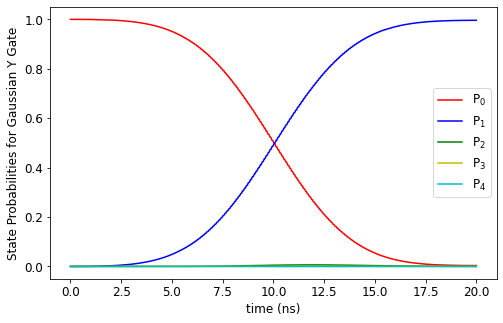

In [42]:
kmax = 5
alpha = 300e6 * 2 * np.pi 
detuning = alpha / 2
wq = 5e9 * 2 * np.pi 
wd = wq + detuning
phi_d = np.pi / 4
Gate_duration = 20e-9
t_0 = Gate_duration / 2
sigma = Gate_duration / 4
amp = optimal_gaussian_amplitude
dragamp = optimal_drag_amplitude
Q = np.sin(phi_d)
I = np.cos(phi_d)
λ = 0.1
B = (-λ**2) / 4 / alpha
tList = np.arange(0, Gate_duration, 1e-12)

def gaussian(t, args):
    return np.exp(-((t - args["t_0"]) / args["sigma"])**2 / 2)

def gaussian_drive_y(t, args):
    return args["Q"] * np.cos((args["wd"] * t) + np.pi) * gaussian(t, args)

args = {'t_0': t_0, 'sigma': sigma , 'wd': wd, 'wq': wq ,'I': I, 'Q': Q}

b = destroy(kmax)
H0 = wq * (b.dag() * b) + alpha / 2 * (b.dag() * b)**2
Hd_sigmax = amp * (b + b.dag())
Hd_sigmay = amp * (1j * (b - b.dag()))

H_y = [H0, [Hd_sigmay, gaussian_drive_y]]
c_ops = []
opts = Options(atol=1e-12, rtol=1e-10, store_states=True, nsteps=1e7)
result_y = mesolve(H_y, ket2dm(fock(kmax, 0)), tList, c_ops, [], args=args, options=opts, progress_bar=True)

probabilities_y = calculate_probability_from_dm(result_y)
print(probabilities_y[-1,1])
plt.figure(figsize=(8, 5))
plt.plot(tList*1e9, probabilities_y[:,0], 'r')
plt.plot(tList*1e9, probabilities_y[:,1], 'b')
plt.plot(tList*1e9, probabilities_y[:,2], 'g')
plt.plot(tList*1e9, probabilities_y[:,3], 'y')
plt.plot(tList*1e9, probabilities_y[:,4], 'c')
plt.xlabel("time (ns)", fontsize=12)
plt.ylabel("State Probabilities for Gaussian Y Gate", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.rc('grid', linestyle=":", color='black')
plt.legend([r"$\mathrm{P_0}$", r"$\mathrm{P_1}$", r"$\mathrm{P_2}$", r"$\mathrm{P_3}$",r"$\mathrm{P_4}$"], loc='best' , fontsize=12)

### Bloch sphere of Y gate

In [26]:
nmax = 2
alpha = 300e6 * 2 * np.pi 
detuning = alpha / 2
wq = 5e9 * 2 * np.pi 
wd = wq + detuning
phi_d = np.pi / 4
Gate_duration = 20e-9
t_0 = Gate_duration / 2
sigma = Gate_duration / 4
amp = optimal_gaussian_amplitude
dragamp = optimal_drag_amplitude
Q = np.sin(phi_d)
I = np.cos(phi_d)
λ = 0.1
B = (-λ**2) / 4 / alpha
tList = np.arange(0, Gate_duration, 1e-10)

def gaussian(t, args):
    return np.exp(-((t - args["t_0"]) / args["sigma"])**2 / 2)

def gaussian_drive_y(t, args):
    return args["Q"] * np.cos((args["wd"] * t) + np.pi) * gaussian(t, args)

args = {'t_0': t_0, 'sigma': sigma , 'wd': wd, 'wq': wq ,'I': I, 'Q': Q}

b = destroy(nmax)
H0 = wq * (b.dag() * b) + alpha / 2 * (b.dag() * b)**2
Hd_sigmax = amp * (b + b.dag())
Hd_sigmay = amp * (1j * (b - b.dag()))

H_y = [H0, [Hd_sigmay, gaussian_drive_y]]
c_ops = []
opts = Options(atol=1e-12, rtol=1e-10, store_states=True, nsteps=1e7)
result_y = mesolve(H_y, ket2dm(fock(nmax, 0)), tList, c_ops, [], args=args, options=opts, progress_bar=True)

states = result_y.states

def animate_bloch(states, duration=0.1, save_all=False):
    b = Bloch()
    b.vector_color = ['r']
    b.view = [140, 30]
    images = []
    
    length = len(states)
    nrm = mpl_colors.Normalize(0, length)
    colors = cm.cool(nrm(range(length)))
    b.point_color = list(colors)
    b.point_marker = ['o']
    b.point_size = [30]
    
    for i in range(length):
        b.clear()
        b.add_states(states[i])
        b.add_states(states[:(i+1)], 'point')
        if save_all:
            filename = "tmp/bloch_%01d.png" % i
            b.save(filename)
        else:
            filename = 'bloch_anim_gaussian_and_DRAG_pulse_Y_gate.png'
            b.save(filename)
        images.append(imageio.imread(filename))

    imageio.mimsave('bloch_anim_gaussian_and_DRAG_pulse_Y_gate.gif', images, duration=duration)

states_y = result_y.states
animate_bloch(states_y)

10.1%. Run time:   0.03s. Est. time left: 00:00:00:00
20.1%. Run time:   0.05s. Est. time left: 00:00:00:00
30.2%. Run time:   0.07s. Est. time left: 00:00:00:00
40.2%. Run time:   0.09s. Est. time left: 00:00:00:00
50.3%. Run time:   0.12s. Est. time left: 00:00:00:00
60.3%. Run time:   0.14s. Est. time left: 00:00:00:00
70.4%. Run time:   0.15s. Est. time left: 00:00:00:00
80.4%. Run time:   0.17s. Est. time left: 00:00:00:00
90.5%. Run time:   0.19s. Est. time left: 00:00:00:00
100.0%. Run time:   0.21s. Est. time left: 00:00:00:00
Total run time:   0.21s


### Z gate 
To read :
1. https://quantumcomputinguk.org/tutorials/z-gate

In [27]:
nmax = 2
b = destroy(nmax)
sigma_z = sigmaz()
sigma__z = b * b.dag() - b.dag() * b

print(sigma_z)
print(sigma__z)
print(sigma_z == sigma__z)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dia, isherm=True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]
True


10.0%. Run time:   0.15s. Est. time left: 00:00:00:01
20.0%. Run time:   0.35s. Est. time left: 00:00:00:01
30.0%. Run time:   0.59s. Est. time left: 00:00:00:01
40.0%. Run time:   0.88s. Est. time left: 00:00:00:01
50.0%. Run time:   1.06s. Est. time left: 00:00:00:01
60.0%. Run time:   1.24s. Est. time left: 00:00:00:00
70.0%. Run time:   1.48s. Est. time left: 00:00:00:00
80.0%. Run time:   1.72s. Est. time left: 00:00:00:00
90.0%. Run time:   1.91s. Est. time left: 00:00:00:00
100.0%. Run time:   2.12s. Est. time left: 00:00:00:00
Total run time:   2.12s
0.996330716790701


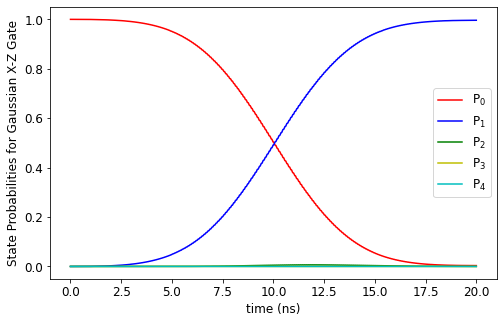

In [54]:
kmax = 5
alpha = 300e6 * 2 * np.pi 
detuning = alpha / 2
wq = 5e9 * 2 * np.pi 
wd = wq + detuning
phi_d = np.pi / 4
Gate_duration = 20e-9
t_0 = Gate_duration / 2
sigma = Gate_duration / 4
amp = optimal_gaussian_amplitude
dragamp = optimal_drag_amplitude
Q = np.sin(phi_d)
I = np.cos(phi_d)
λ = 0.1
B = (-λ**2) / 4 / alpha
tList = np.arange(0, Gate_duration, 1e-12)

def gaussian(t, args):
    return np.exp(-((t - args["t_0"]) / args["sigma"])**2 / 2)

def gaussian_drive_z(t, args):
    return args["Q"] * np.cos(args["wd"] * t + np.pi) * gaussian(t, args)

args = {'t_0': t_0, 'sigma': sigma , 'wd': wd, 'wq': wq ,'I': I, 'Q': Q}

b = destroy(kmax)
H0 = wq * (b.dag() * b) + alpha / 2 * (b.dag() * b)**2
Hd_sigmax = amp * (b + b.dag())
Hd_sigmay = amp * (1j * (b - b.dag()))
Hd_sigmaz = amp * (b * b.dag() - b.dag() * b)
H_zx = [H0, [Hd_sigmax, gaussian_drive_x], [Hd_sigmaz, gaussian_drive_z]]
c_ops = []
opts = Options(atol=1e-12, rtol=1e-10, store_states=True, nsteps=1e7)
result_zx = mesolve(H_zx, ket2dm(fock(kmax, 0)), tList, c_ops, [], args=args, options=opts, progress_bar=True)

probabilities_zx = calculate_probability_from_dm(result_zx)
print(probabilities_zx[-1,1])
plt.figure(figsize=(8, 5))
plt.plot(tList*1e9, probabilities_zx[:,0], 'r')
plt.plot(tList*1e9, probabilities_zx[:,1], 'b')
plt.plot(tList*1e9, probabilities_zx[:,2], 'g')
plt.plot(tList*1e9, probabilities_zx[:,3], 'y')
plt.plot(tList*1e9, probabilities_zx[:,4], 'c')
plt.xlabel("time (ns)", fontsize=12)
plt.ylabel("State Probabilities for Gaussian X-Z Gate", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.rc('grid', linestyle=":", color='black')
plt.legend([r"$\mathrm{P_0}$", r"$\mathrm{P_1}$", r"$\mathrm{P_2}$", r"$\mathrm{P_3}$",r"$\mathrm{P_4}$"], loc='best' , fontsize=12)

In [56]:
print(probabilities_zx[-1,1]-probabilities_x[-1,1])

2.245592600758073e-11


10.0%. Run time:   0.18s. Est. time left: 00:00:00:01
20.0%. Run time:   0.40s. Est. time left: 00:00:00:01
30.0%. Run time:   0.61s. Est. time left: 00:00:00:01
40.0%. Run time:   0.82s. Est. time left: 00:00:00:01
50.0%. Run time:   1.25s. Est. time left: 00:00:00:01
60.0%. Run time:   1.50s. Est. time left: 00:00:00:00
70.0%. Run time:   1.77s. Est. time left: 00:00:00:00
80.0%. Run time:   2.00s. Est. time left: 00:00:00:00
90.0%. Run time:   2.17s. Est. time left: 00:00:00:00
100.0%. Run time:   2.35s. Est. time left: 00:00:00:00
Total run time:   2.35s
0.9961802377881572


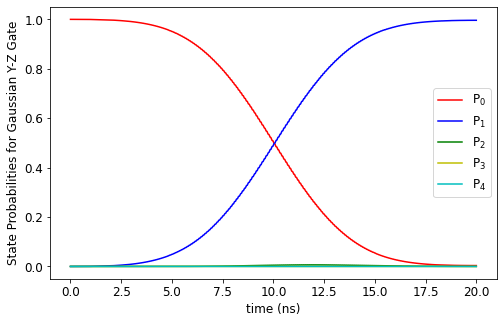

In [57]:
kmax = 5
alpha = 300e6 * 2 * np.pi 
detuning = alpha / 2
wq = 5e9 * 2 * np.pi 
wd = wq + detuning
phi_d = np.pi / 4
Gate_duration = 20e-9
t_0 = Gate_duration / 2
sigma = Gate_duration / 4
amp = optimal_gaussian_amplitude
dragamp = optimal_drag_amplitude
Q = np.sin(phi_d)
I = np.cos(phi_d)
λ = 0.1
B = (-λ**2) / 4 / alpha
tList = np.arange(0, Gate_duration, 1e-12)

def gaussian(t, args):
    return np.exp(-((t - args["t_0"]) / args["sigma"])**2 / 2)

def gaussian_drive_z(t, args):
    return args["Q"] * np.cos(args["wd"] * t + np.pi) * gaussian(t, args)

args = {'t_0': t_0, 'sigma': sigma , 'wd': wd, 'wq': wq ,'I': I, 'Q': Q}

b = destroy(kmax)
H0 = wq * (b.dag() * b) + alpha / 2 * (b.dag() * b)**2
Hd_sigmax = amp * (b + b.dag())
Hd_sigmay = amp * (1j * (b - b.dag()))
Hd_sigmaz = amp * (b * b.dag() - b.dag() * b)
H_zy = [H0, [Hd_sigmay, gaussian_drive_y], [Hd_sigmaz, gaussian_drive_z]]
c_ops = []
opts = Options(atol=1e-12, rtol=1e-10, store_states=True, nsteps=1e7)
result_zy = mesolve(H_zy, ket2dm(fock(kmax, 0)), tList, c_ops, [], args=args, options=opts, progress_bar=True)

probabilities_zy = calculate_probability_from_dm(result_zy)
plt.figure(figsize=(8, 5))
plt.plot(tList*1e9, probabilities_zy[:,0], 'r')
plt.plot(tList*1e9, probabilities_zy[:,1], 'b')
plt.plot(tList*1e9, probabilities_zy[:,2], 'g')
plt.plot(tList*1e9, probabilities_zy[:,3], 'y')
plt.plot(tList*1e9, probabilities_zy[:,4], 'c')
plt.xlabel("time (ns)", fontsize=12)
plt.ylabel("State Probabilities for Gaussian Y-Z Gate", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.rc('grid', linestyle=":", color='black')
plt.legend([r"$\mathrm{P_0}$", r"$\mathrm{P_1}$", r"$\mathrm{P_2}$", r"$\mathrm{P_3}$",r"$\mathrm{P_4}$"], loc='best' , fontsize=12)
print(probabilities_zy[-1,1])

In [58]:
print(probabilities_zy[-1,1]-probabilities_y[-1,1])

1.8500534437748684e-11


### Bloch sphere of ZY gate

In [ ]:
nmax = 2
alpha = 300e6 * 2 * np.pi 
detuning = alpha / 2
wq = 5e9 * 2 * np.pi 
wd = wq + detuning
phi_d = np.pi / 4
Gate_duration = 20e-9
t_0 = Gate_duration / 2
sigma = Gate_duration / 4
amp = optimal_gaussian_amplitude
dragamp = optimal_drag_amplitude
Q = np.sin(phi_d)
I = np.cos(phi_d)
λ = 0.1
B = (-λ**2) / 4 / alpha
tList = np.arange(0, Gate_duration, 1e-12)

def gaussian(t, args):
    return np.exp(-((t - args["t_0"]) / args["sigma"])**2 / 2)

def gaussian_drive_z(t, args):
    return args["Q"] * np.cos(args["wd"] * t + np.pi) * gaussian(t, args)

args = {'t_0': t_0, 'sigma': sigma , 'wd': wd, 'wq': wq ,'I': I, 'Q': Q}

b = destroy(nmax)
H0 = wq * (b.dag() * b) + alpha / 2 * (b.dag() * b)**2
Hd_sigmax = amp * (b + b.dag())
Hd_sigmay = amp * (1j * (b - b.dag()))
Hd_sigmaz = amp * (b * b.dag() - b.dag() * b)
H_zy = [H0, [Hd_sigmay, gaussian_drive_y], [Hd_sigmaz, gaussian_drive_z]]
c_ops = []
opts = Options(atol=1e-12, rtol=1e-10, store_states=True, nsteps=1e7)
result_zy = mesolve(H_zy, ket2dm(fock(nmax, 0)), tList, c_ops, [], args=args, options=opts, progress_bar=True)

states = result_zy.states

def animate_bloch(states, duration=0.1, save_all=False):
    b = Bloch()
    b.vector_color = ['r']
    b.view = [140, 30]
    images = []
    
    length = len(states)
    nrm = mpl_colors.Normalize(0, length)
    colors = cm.cool(nrm(range(length)))
    b.point_color = list(colors)
    b.point_marker = ['o']
    b.point_size = [30]
    
    for i in range(length):
        b.clear()
        b.add_states(states[i])
        b.add_states(states[:(i+1)], 'point')
        if save_all:
            filename = "tmp/bloch_%01d.png" % i
            b.save(filename)
        else:
            filename = 'bloch_anim_gaussian_and_DRAG_pulse_Z_gate.png'
            b.save(filename)
        images.append(imageio.imread(filename))

    imageio.mimsave('bloch_anim_gaussian_and_DRAG_pulse_Z_gate.gif', images, duration=duration)

states_zy = result_zy.states
animate_bloch(states_zy)

10.0%. Run time:   0.16s. Est. time left: 00:00:00:01
20.0%. Run time:   0.30s. Est. time left: 00:00:00:01
30.0%. Run time:   0.51s. Est. time left: 00:00:00:01
40.0%. Run time:   0.67s. Est. time left: 00:00:00:01
50.0%. Run time:   0.79s. Est. time left: 00:00:00:00
60.0%. Run time:   0.93s. Est. time left: 00:00:00:00
70.0%. Run time:   1.05s. Est. time left: 00:00:00:00
80.0%. Run time:   1.22s. Est. time left: 00:00:00:00
90.0%. Run time:   1.38s. Est. time left: 00:00:00:00
100.0%. Run time:   1.51s. Est. time left: 00:00:00:00
Total run time:   1.51s


In [16]:
sigmax()

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]

https://physics.stackexchange.com/questions/287542/spin-representation-in-3d

In [18]:
nmax = 2
b = destroy(nmax)
b.dag() + b

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]

# Fidelity limit:
The theoretical coherence limit for the gate fidelity is computed based on gate duration( $t_{\rm gate}$ ), $T_1$, and $T_2^*$ :

$$
F = \frac{1}{6} \left(3 + e^{-t_{\rm gate}/T_1} + 2e^{-t_{\rm gate}/T_2^e}\right)
$$

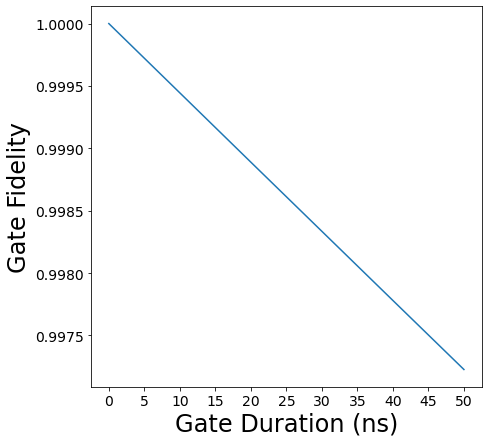

In [46]:
T_1 = 8.6e-6
T_2 = 9.2e-6

def fidelity(tList, T_1, T_2):
    return 1/6 * (3 + np.exp(- tList / T_1 ) + 2 * np.exp(- tList / T_2))

tList = np.arange(0e-9, 50e-9, 1e-12)
fidelities = fidelity(tList, T_1, T_2)
plt.figure(figsize=(7, 7))
plt.plot(tList*1e9, fidelities,linewidth=1.5)
plt.xlabel('Gate Duration (ns)', fontsize=24)
plt.xticks(np.arange(0, 55, 5), fontsize=12)
plt.ylabel('Gate Fidelity', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()